# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import tensorflow as tf
tf.__version__

'1.2.1'

In [2]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [3]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [4]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [5]:
def encoder_block(input_layer, filters, strides):
# TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [6]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    merged = layers.concatenate([upsampled, large_ip_layer])

    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(merged, filters)
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [7]:
def fcn_model(inputs, num_classes):
    # TODO Add Encoder Blocks. 
    
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    enc_1 = encoder_block(inputs, filters=64, strides=2) #64
    enc_2 = encoder_block(enc_1, filters=128, strides=2) #32
    enc_3 = encoder_block(enc_2, filters=256, strides=2) #32
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    fcn = conv2d_batchnorm(enc_3, 64, kernel_size=1, strides=1) #32
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    dec_1 = decoder_block(fcn, enc_2, 256)
    dec_2 = decoder_block(dec_1, enc_1, 128)
    dec_3 = decoder_block(dec_2, inputs, 64)
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    mask = layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(dec_3)
    
    
    print("Layers **************** ")
    print(inputs)
    print(enc_1)
    print(enc_2)
    print(enc_3)
    print(fcn)
    print(dec_1)
    print(dec_2)
    print(dec_3)
    print(mask)

    return mask

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Layers **************** 
Tensor("input_1:0", shape=(?, 160, 160, 3), dtype=float32)
Tensor("batch_normalization/batchnorm/add_1:0", shape=(?, 80, 80, 64), dtype=float32)
Tensor("batch_normalization_2/batchnorm/add_1:0", shape=(?, 40, 40, 128), dtype=float32)
Tensor("batch_normalization_3/batchnorm/add_1:0", shape=(?, 20, 20, 256), dtype=float32)
Tensor("batch_normalization_4/batchnorm/add_1:0", shape=(?, 20, 20, 64), dtype=float32)
Tensor("batch_normalization_6/batchnorm/add_1:0", shape=(?, 40, 40, 256), dtype=float32)
Tensor("batch_normalization_8/batchnorm/add_1:0", shape=(?, 80, 80, 128), dtype=float32)
Tensor("batch_normalization_10/batchnorm/add_1:0", shape=(?, 160, 160, 64), dtype=float32)
Tensor("conv2d_2/truediv:0", shape=(?, 160, 160, 3), dtype=float32)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [9]:
learning_rate = 0.002
batch_size = 15
num_epochs = 40
steps_per_epoch = 20 #4131//batch_size
validation_steps = 30 #1184 // batch_size
workers = 10

Epoch 1/40
19/20 [===========================>..] - ETA: 7s - loss: 1.0254 

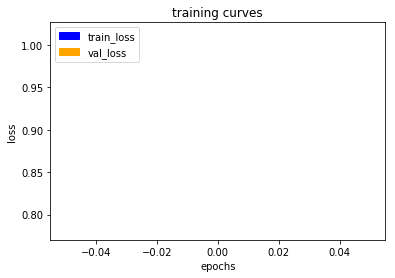

20/20 [==============================] - 215s - loss: 1.0152 - val_loss: 0.7818
Epoch 2/40
19/20 [===========================>..] - ETA: 6s - loss: 0.6325 

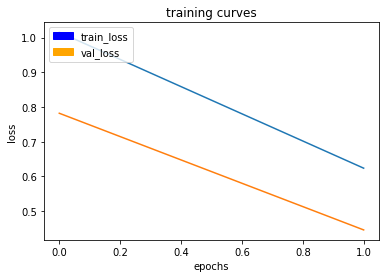

20/20 [==============================] - 191s - loss: 0.6236 - val_loss: 0.4458
Epoch 3/40
19/20 [===========================>..] - ETA: 6s - loss: 0.3148 

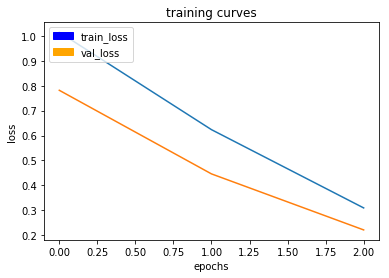

20/20 [==============================] - 201s - loss: 0.3090 - val_loss: 0.2206
Epoch 4/40
19/20 [===========================>..] - ETA: 6s - loss: 0.1456 

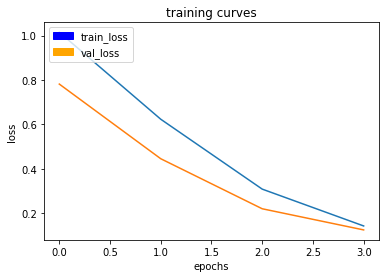

20/20 [==============================] - 191s - loss: 0.1432 - val_loss: 0.1253
Epoch 5/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0845 

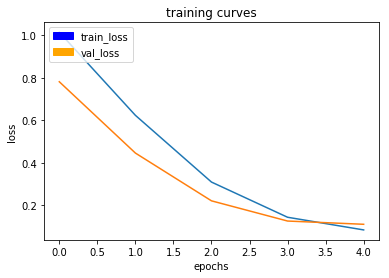

20/20 [==============================] - 195s - loss: 0.0835 - val_loss: 0.1100
Epoch 6/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0743 

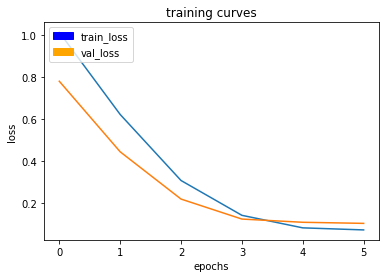

20/20 [==============================] - 202s - loss: 0.0737 - val_loss: 0.1049
Epoch 7/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0591 

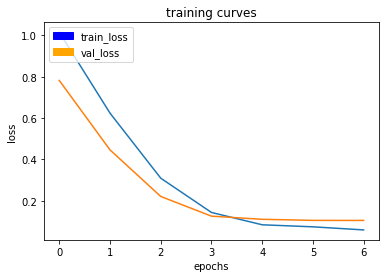

20/20 [==============================] - 196s - loss: 0.0587 - val_loss: 0.1045
Epoch 8/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0516 

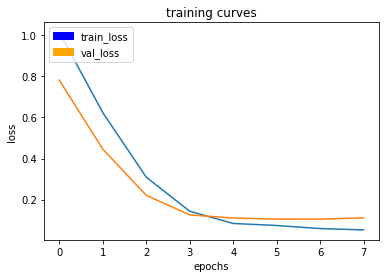

20/20 [==============================] - 194s - loss: 0.0521 - val_loss: 0.1109
Epoch 9/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0403 

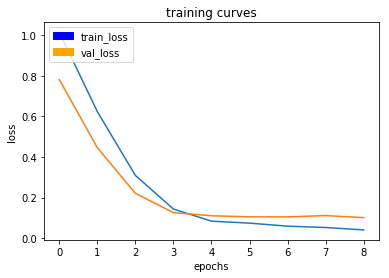

20/20 [==============================] - 194s - loss: 0.0402 - val_loss: 0.1009
Epoch 10/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0473 

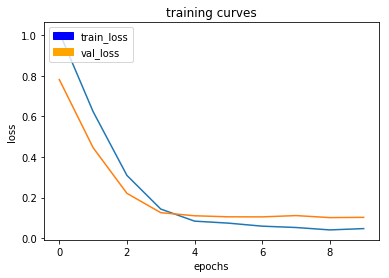

20/20 [==============================] - 197s - loss: 0.0467 - val_loss: 0.1022
Epoch 11/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0496 

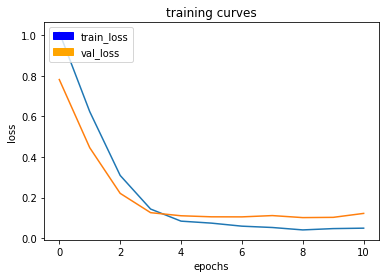

20/20 [==============================] - 191s - loss: 0.0488 - val_loss: 0.1217
Epoch 12/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0366 

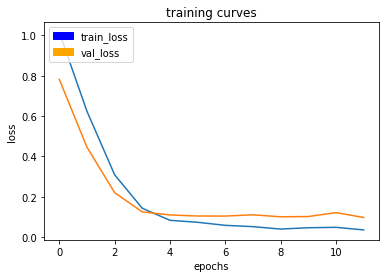

20/20 [==============================] - 191s - loss: 0.0360 - val_loss: 0.0976
Epoch 13/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0367 

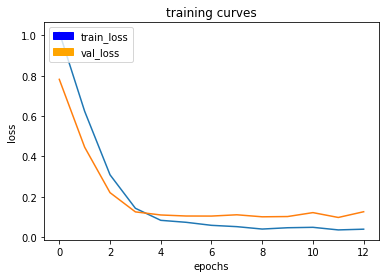

20/20 [==============================] - 209s - loss: 0.0396 - val_loss: 0.1260
Epoch 14/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0328 

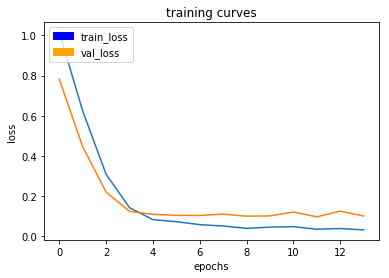

20/20 [==============================] - 214s - loss: 0.0330 - val_loss: 0.1016
Epoch 15/40
19/20 [===========================>..] - ETA: 7s - loss: 0.0308 

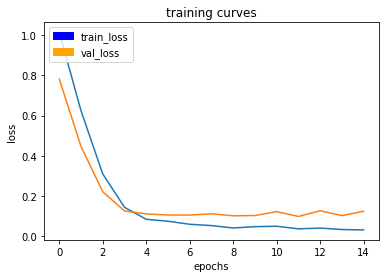

20/20 [==============================] - 219s - loss: 0.0306 - val_loss: 0.1233
Epoch 16/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0352 

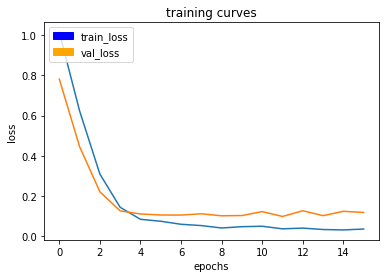

20/20 [==============================] - 214s - loss: 0.0350 - val_loss: 0.1175
Epoch 17/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0408 

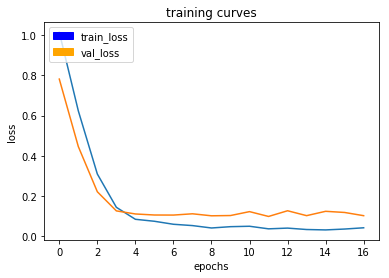

20/20 [==============================] - 216s - loss: 0.0412 - val_loss: 0.1015
Epoch 18/40
19/20 [===========================>..] - ETA: 7s - loss: 0.0307 

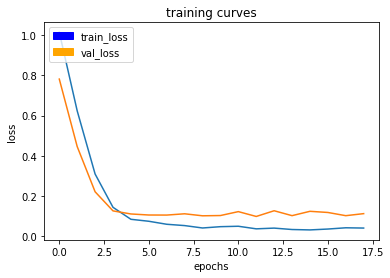

20/20 [==============================] - 216s - loss: 0.0398 - val_loss: 0.1117
Epoch 19/40
19/20 [===========================>..] - ETA: 7s - loss: 0.0317 

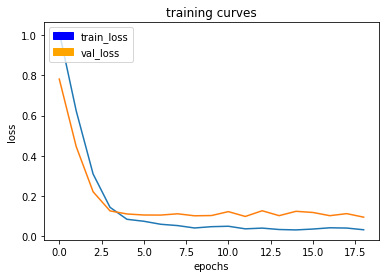

20/20 [==============================] - 225s - loss: 0.0314 - val_loss: 0.0941
Epoch 20/40
19/20 [===========================>..] - ETA: 7s - loss: 0.0273 

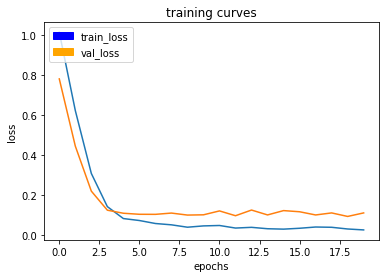

20/20 [==============================] - 216s - loss: 0.0267 - val_loss: 0.1117
Epoch 21/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0318 

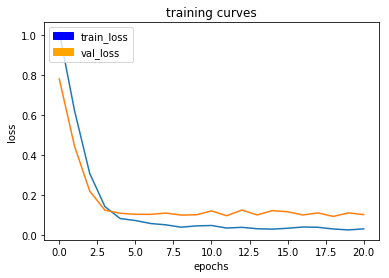

20/20 [==============================] - 214s - loss: 0.0319 - val_loss: 0.1034
Epoch 22/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0240 

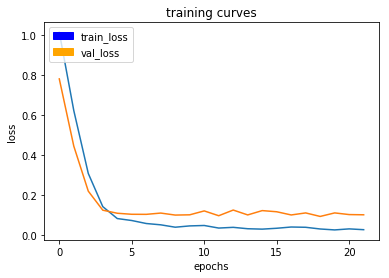

20/20 [==============================] - 214s - loss: 0.0278 - val_loss: 0.1023
Epoch 23/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0258 

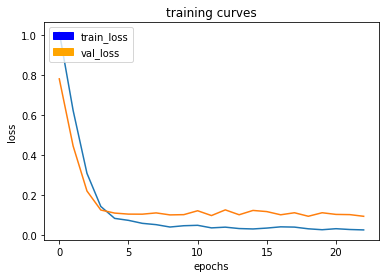

20/20 [==============================] - 215s - loss: 0.0258 - val_loss: 0.0939
Epoch 24/40
19/20 [===========================>..] - ETA: 7s - loss: 0.0310 

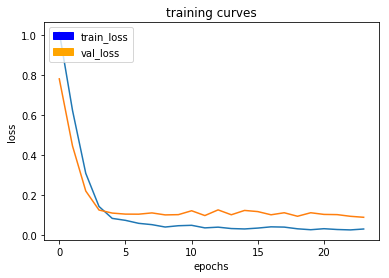

20/20 [==============================] - 220s - loss: 0.0303 - val_loss: 0.0890
Epoch 25/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0278 

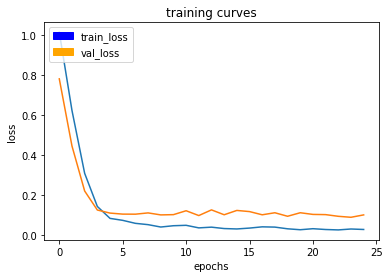

20/20 [==============================] - 213s - loss: 0.0280 - val_loss: 0.1009
Epoch 26/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0363 

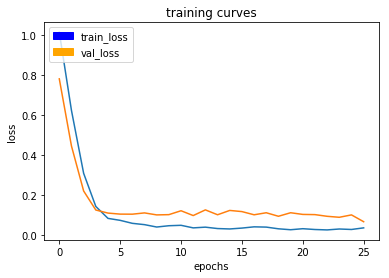

20/20 [==============================] - 213s - loss: 0.0360 - val_loss: 0.0668
Epoch 27/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0357 

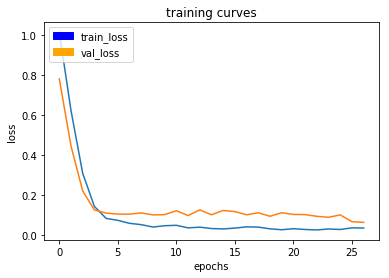

20/20 [==============================] - 214s - loss: 0.0352 - val_loss: 0.0636
Epoch 28/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0278 

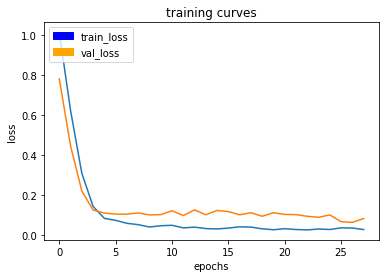

20/20 [==============================] - 196s - loss: 0.0274 - val_loss: 0.0828
Epoch 29/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0259 

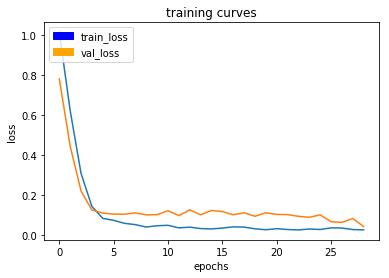

20/20 [==============================] - 193s - loss: 0.0259 - val_loss: 0.0428
Epoch 30/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0258 

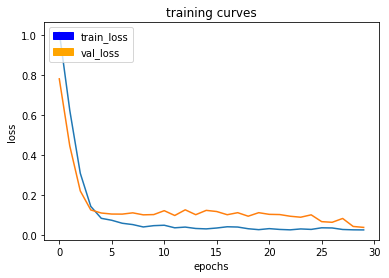

20/20 [==============================] - 193s - loss: 0.0254 - val_loss: 0.0380
Epoch 31/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0292 

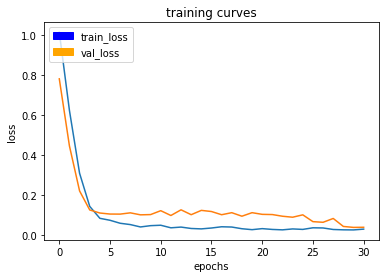

20/20 [==============================] - 187s - loss: 0.0294 - val_loss: 0.0387
Epoch 32/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0238 

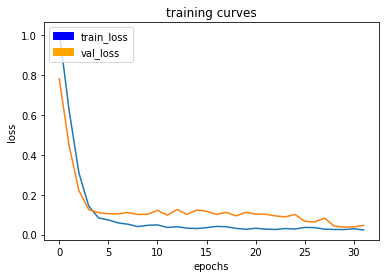

20/20 [==============================] - 193s - loss: 0.0236 - val_loss: 0.0466
Epoch 33/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0272 

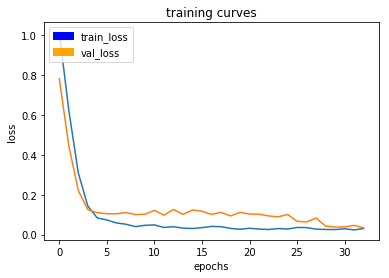

20/20 [==============================] - 205s - loss: 0.0305 - val_loss: 0.0337
Epoch 34/40
19/20 [===========================>..] - ETA: 7s - loss: 0.0397 

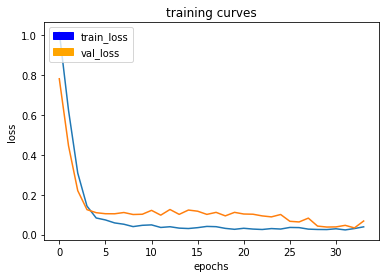

20/20 [==============================] - 220s - loss: 0.0391 - val_loss: 0.0683
Epoch 35/40
19/20 [===========================>..] - ETA: 7s - loss: 0.0346 

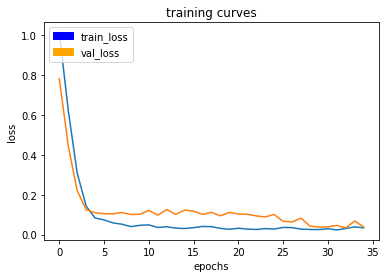

20/20 [==============================] - 216s - loss: 0.0341 - val_loss: 0.0389
Epoch 36/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0313 

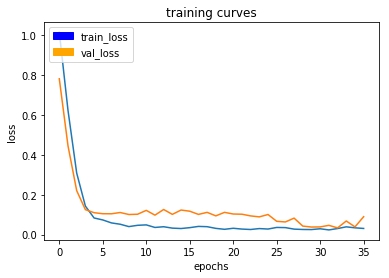

20/20 [==============================] - 215s - loss: 0.0310 - val_loss: 0.0899
Epoch 37/40
19/20 [===========================>..] - ETA: 7s - loss: 0.0265 

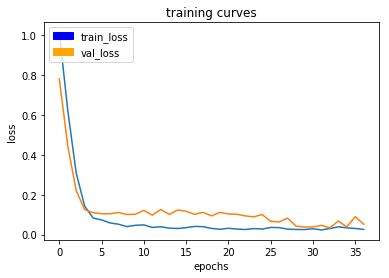

20/20 [==============================] - 210s - loss: 0.0262 - val_loss: 0.0523
Epoch 38/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0226 

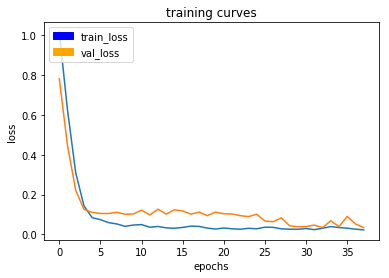

20/20 [==============================] - 189s - loss: 0.0223 - val_loss: 0.0340
Epoch 39/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0266 

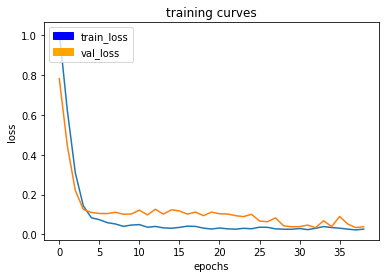

20/20 [==============================] - 188s - loss: 0.0262 - val_loss: 0.0382
Epoch 40/40
19/20 [===========================>..] - ETA: 6s - loss: 0.0234 

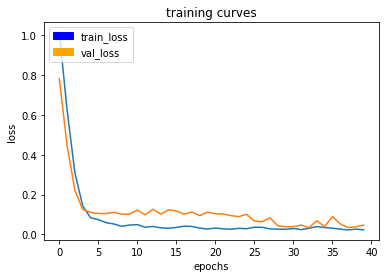

20/20 [==============================] - 193s - loss: 0.0230 - val_loss: 0.0459


In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True, )

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

Epoch 41/55
19/20 [===========================>..] - ETA: 7s - loss: 0.0262 

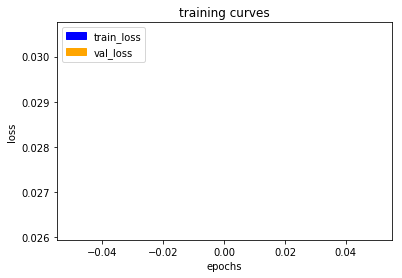

20/20 [==============================] - 214s - loss: 0.0262 - val_loss: 0.0305
Epoch 42/55
19/20 [===========================>..] - ETA: 7s - loss: 0.0205 

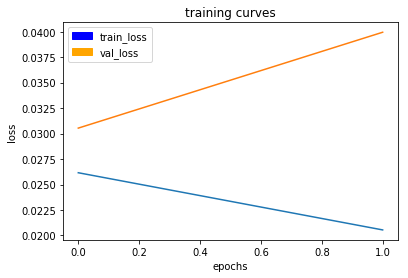

20/20 [==============================] - 215s - loss: 0.0205 - val_loss: 0.0399
Epoch 43/55
19/20 [===========================>..] - ETA: 6s - loss: 0.0252 

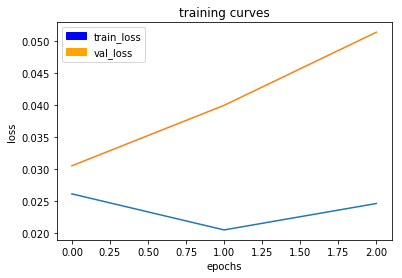

20/20 [==============================] - 209s - loss: 0.0247 - val_loss: 0.0513
Epoch 44/55
19/20 [===========================>..] - ETA: 6s - loss: 0.0279 

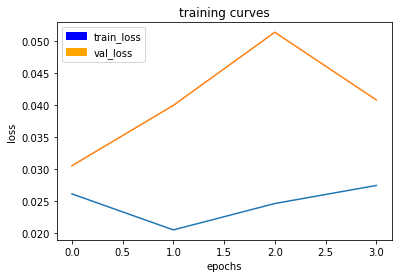

20/20 [==============================] - 199s - loss: 0.0275 - val_loss: 0.0408
Epoch 45/55
19/20 [===========================>..] - ETA: 6s - loss: 0.0222 

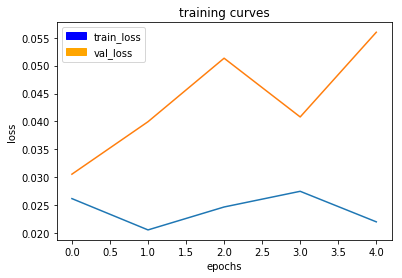

20/20 [==============================] - 185s - loss: 0.0220 - val_loss: 0.0560
Epoch 46/55
19/20 [===========================>..] - ETA: 6s - loss: 0.0338 

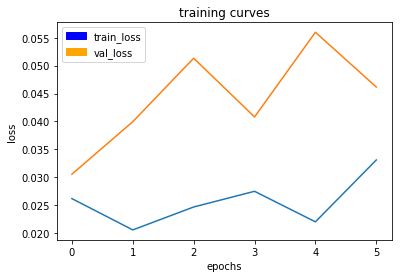

20/20 [==============================] - 192s - loss: 0.0331 - val_loss: 0.0462
Epoch 47/55
19/20 [===========================>..] - ETA: 6s - loss: 0.0222 

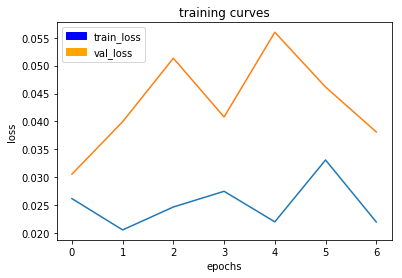

20/20 [==============================] - 190s - loss: 0.0220 - val_loss: 0.0381
Epoch 48/55
19/20 [===========================>..] - ETA: 6s - loss: 0.0188 

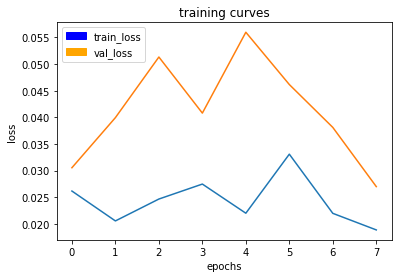

20/20 [==============================] - 186s - loss: 0.0189 - val_loss: 0.0270
Epoch 49/55
19/20 [===========================>..] - ETA: 6s - loss: 0.0303 

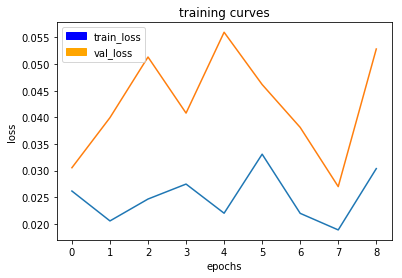

20/20 [==============================] - 184s - loss: 0.0304 - val_loss: 0.0528
Epoch 50/55
19/20 [===========================>..] - ETA: 6s - loss: 0.0280 

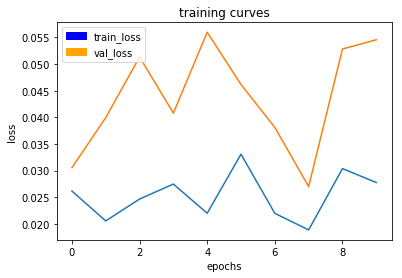

20/20 [==============================] - 186s - loss: 0.0278 - val_loss: 0.0546
Epoch 51/55
19/20 [===========================>..] - ETA: 6s - loss: 0.0214 

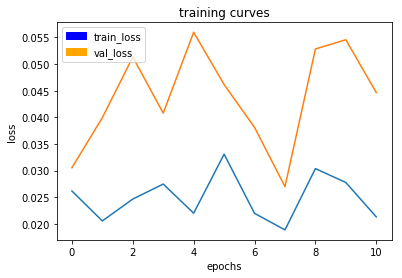

20/20 [==============================] - 210s - loss: 0.0213 - val_loss: 0.0446
Epoch 52/55
19/20 [===========================>..] - ETA: 6s - loss: 0.0223 

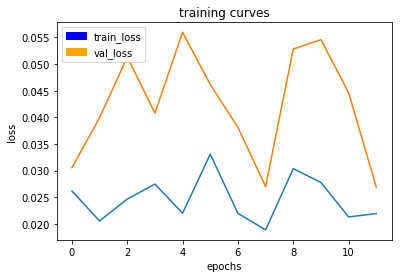

20/20 [==============================] - 191s - loss: 0.0219 - val_loss: 0.0269
Epoch 53/55
19/20 [===========================>..] - ETA: 6s - loss: 0.0195 

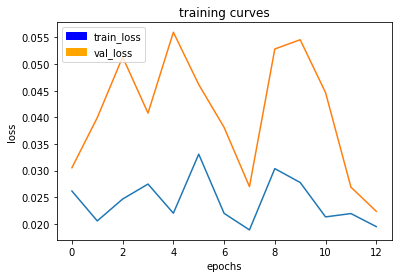

20/20 [==============================] - 200s - loss: 0.0195 - val_loss: 0.0223
Epoch 54/55
19/20 [===========================>..] - ETA: 6s - loss: 0.0195 

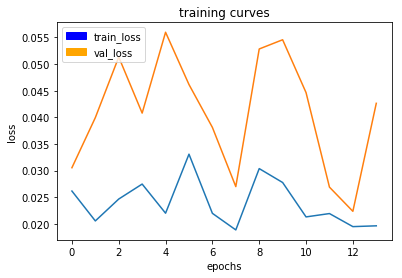

20/20 [==============================] - 207s - loss: 0.0198 - val_loss: 0.0426
Epoch 55/55
19/20 [===========================>..] - ETA: 6s - loss: 0.0173 

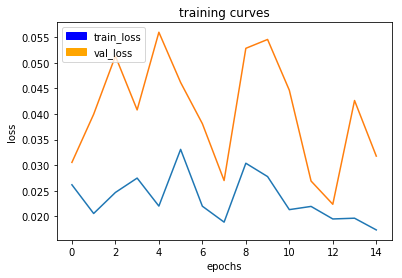

20/20 [==============================] - 210s - loss: 0.0173 - val_loss: 0.0318


In [24]:
# Extend the training to more EPOCH and reduction of learning rate
learning_rate_2 = 0.001
num_epochs_2 = 55

train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

model.compile(optimizer=keras.optimizers.Adam(learning_rate_2), loss='categorical_crossentropy')
logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]
model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs_2,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers,
                    initial_epoch=num_epochs,
)

Epoch 146/150
19/20 [===========================>..] - ETA: 6s - loss: 0.0127 

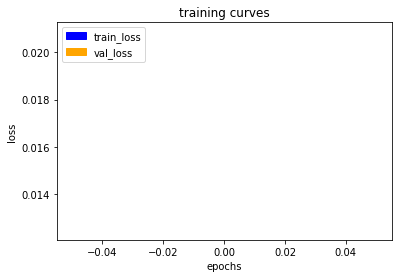

20/20 [==============================] - 185s - loss: 0.0125 - val_loss: 0.0208
Epoch 147/150
19/20 [===========================>..] - ETA: 6s - loss: 0.0149 

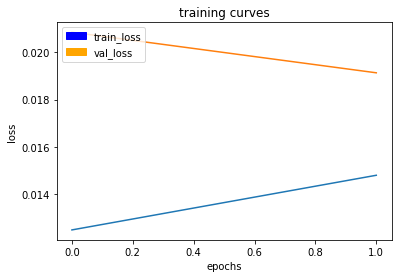

20/20 [==============================] - 208s - loss: 0.0148 - val_loss: 0.0191
Epoch 148/150
19/20 [===========================>..] - ETA: 7s - loss: 0.0133 

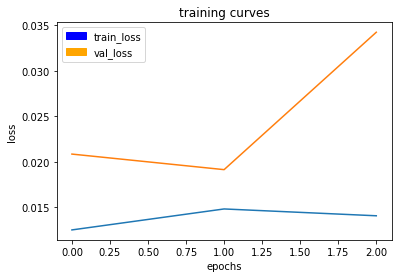

20/20 [==============================] - 211s - loss: 0.0140 - val_loss: 0.0343
Epoch 149/150
19/20 [===========================>..] - ETA: 6s - loss: 0.0143 

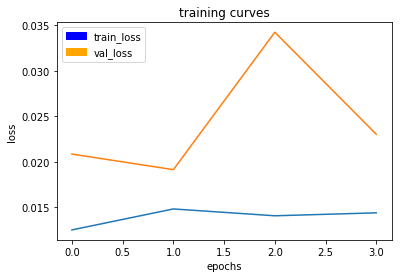

20/20 [==============================] - 198s - loss: 0.0144 - val_loss: 0.0230
Epoch 150/150
19/20 [===========================>..] - ETA: 6s - loss: 0.0130 

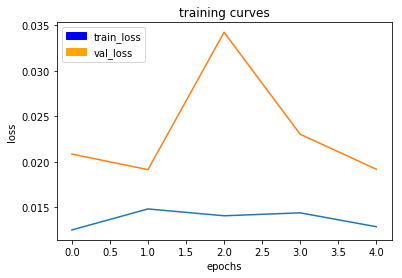

20/20 [==============================] - 188s - loss: 0.0128 - val_loss: 0.0192


In [131]:
# Extend the training to more EPOCH and reduction of learning rate
learning_rate_3 = 0.00005
num_epochs_3 = 150

train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

model.compile(optimizer=keras.optimizers.Adam(learning_rate_3), loss='categorical_crossentropy')
logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]
model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs_3,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers,
                    initial_epoch=145,
)

In [132]:
# Save your trained model weights
weight_file_name = 'model_weights_150epochs'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [133]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [134]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

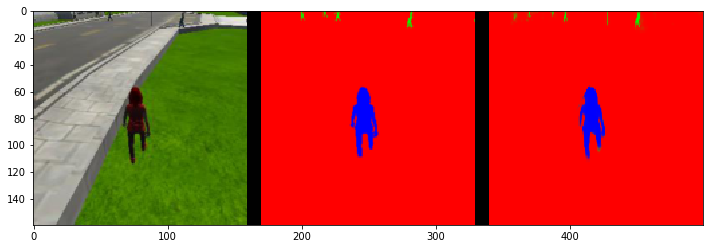

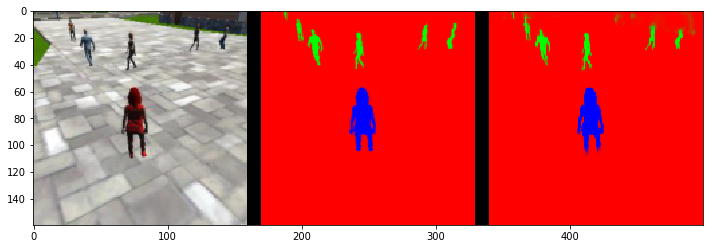

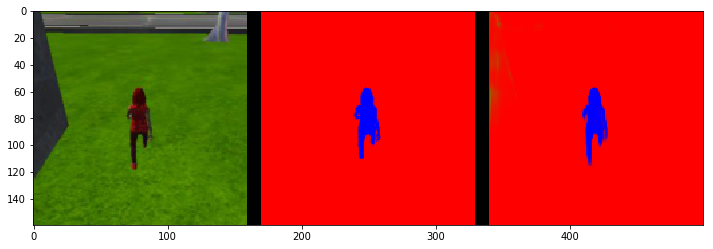

In [135]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

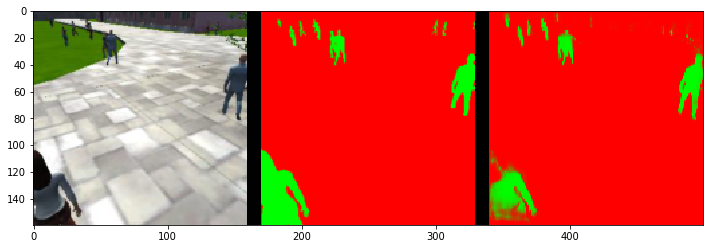

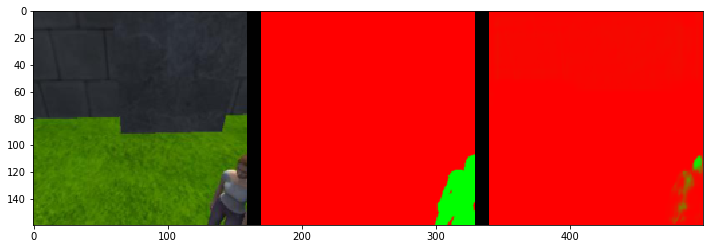

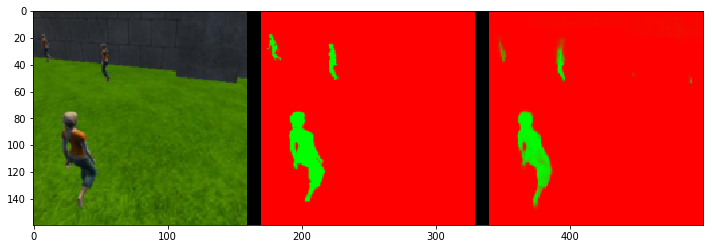

In [136]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

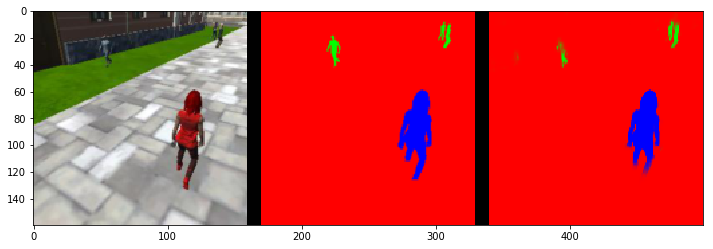

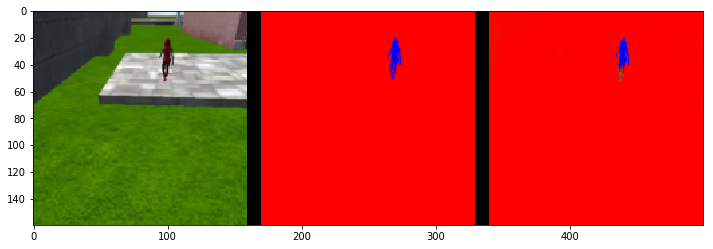

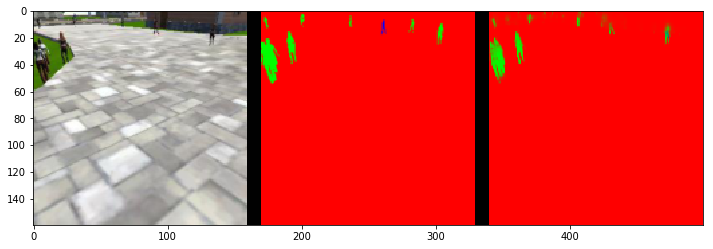

In [137]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [138]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9955948723985762
average intersection over union for other people is 0.34164437856797486
average intersection over union for the hero is 0.9004464415605266
number true positives: 539, number false positives: 0, number false negatives: 0


In [139]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9870605713579573
average intersection over union for other people is 0.7345835264253927
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 35, number false negatives: 0


In [140]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9960171582195675
average intersection over union for other people is 0.4206276593930714
average intersection over union for the hero is 0.17518144259095744
number true positives: 115, number false positives: 1, number false negatives: 186


In [141]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7465753424657534


In [142]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.537813942076


In [143]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.401518627988
